In [1]:
import jax.numpy as jnp
from jax import Array
import numpy as np

from sklearn.datasets import fetch_20newsgroups

import matplotlib.pyplot as plt
import seaborn as sns

from cartm.model import ContextTopicModel
from cartm.prepocessing import DatasetPreprocessor, BatchLoader
from cartm.metrics import (
    Metric,
    PerplexityMetric,
    CoherenceMetric,
    SparsityMetric,
    TopicVarianceMetric,
)

In [2]:
sns.set_theme()

This example notebook shows how to use predefined metrics and write you own custom metrics. Metrics are crucial for evaluating your model, and understanding them can help to choose metric which fits the best for your task. Predefined metrics are common in topic modelling tasks and it is highly recommended that you familiarize yourself with this metrics before you begin using them.

It is also recommended to read `quickstart.ipynb` and `batched_training.ipynb` notebooks first.

In [3]:
data = fetch_20newsgroups(data_home='./data/', subset='all').data
print(f'Total number of documents in corpus: {len(data)}')
print(f'Total number of words in corpus: {sum([len(doc.split(' ')) for doc in data])}')

Total number of documents in corpus: 18846
Total number of words in corpus: 5937230


In [4]:
preprocessor = DatasetPreprocessor()
tokenized_data, document_bounds = preprocessor.fit_transform(data)
print(f'Total number of document boundaries in preprocessed corpus: {len(document_bounds)}')
print(f'Total number of tokenized words in preprocessed corpus: {len(tokenized_data)}')

Total number of document boundaries in preprocessed corpus: 18847
Total number of tokenized words in preprocessed corpus: 3535392


In [5]:
loader = BatchLoader(
    data=tokenized_data,
    doc_bounds=document_bounds,
    batch_size=10000,
)
print(f'Number of batches: {len(loader)}')

Number of batches: 354


## Basic usage of predefined metrics

### Creating new metric

Each metric represents a subclass of abstract class `Metric`. To define a new metric and evaluate your model during training, you can create an instance of the metric you need and pass it to constructor of the model. Alternatively, you can use `add_metric` method of `ContextTopicModel` class to add a new metric after the creation of the model. To remove a metric from the model, use `remove_metric` method.

Metrics calculated after each step are logged. Verbosity of logs can be controlled by setting the `verbose` parameter.

In [6]:
perplexity = PerplexityMetric()

model = ContextTopicModel(
    vocab_size=len(preprocessor.vocabulary),
    ctx_len=10,
    metrics=[perplexity],
)

model.fit(
    data=tokenized_data,
    ctx_bounds=document_bounds,
    max_iter=5,
    verbose=2,  # set this value to >=2 to show metrics in logs
    seed=42,
)

Iteration [1/5], phi update diff norm: 0.1438
  Metrics:
    PerplexityMetric: 90600.5938
Iteration [2/5], phi update diff norm: 0.0242
  Metrics:
    PerplexityMetric: 4119.5635
Iteration [3/5], phi update diff norm: 0.0288
  Metrics:
    PerplexityMetric: 4017.1748
Iteration [4/5], phi update diff norm: 0.0409
  Metrics:
    PerplexityMetric: 3885.6040
Iteration [5/5], phi update diff norm: 0.0508
  Metrics:
    PerplexityMetric: 3698.9846


In [7]:
perplexity = PerplexityMetric()

model = ContextTopicModel(
    vocab_size=len(preprocessor.vocabulary),
    ctx_len=10,
)
model.add_metric(perplexity)

model.fit(
    data=tokenized_data,
    ctx_bounds=document_bounds,
    max_iter=5,
    verbose=2,
    seed=42,
)

Iteration [1/5], phi update diff norm: 0.1438
  Metrics:
    PerplexityMetric: 90600.5938
Iteration [2/5], phi update diff norm: 0.0242
  Metrics:
    PerplexityMetric: 4119.5635
Iteration [3/5], phi update diff norm: 0.0288
  Metrics:
    PerplexityMetric: 4017.1748
Iteration [4/5], phi update diff norm: 0.0409
  Metrics:
    PerplexityMetric: 3885.6040
Iteration [5/5], phi update diff norm: 0.0508
  Metrics:
    PerplexityMetric: 3698.9846


In [8]:
model.remove_metric(tag='PerplexityMetric')
model.fit(
    data=tokenized_data,
    ctx_bounds=document_bounds,
    max_iter=5,
    verbose=2,
    seed=42,
)

Iteration [1/5], phi update diff norm: 0.1438
Iteration [2/5], phi update diff norm: 0.0242
Iteration [3/5], phi update diff norm: 0.0288
Iteration [4/5], phi update diff norm: 0.0409
Iteration [5/5], phi update diff norm: 0.0508


### Tagging metrics

Metrics support tags (labels) for custom naming of metrics. Thus, you can use one metric with different parameters in one model.

In [9]:
perplexity = PerplexityMetric(tag='tagged_metric')

model = ContextTopicModel(
    vocab_size=len(preprocessor.vocabulary),
    ctx_len=10,
    metrics=[perplexity],
)

model.fit(
    data=tokenized_data,
    ctx_bounds=document_bounds,
    max_iter=5,
    verbose=2,  # set this value to >=2 to show metrics in logs
    seed=42,
)

Iteration [1/5], phi update diff norm: 0.1438
  Metrics:
    tagged_metric: 90600.5938
Iteration [2/5], phi update diff norm: 0.0242
  Metrics:
    tagged_metric: 4119.5635
Iteration [3/5], phi update diff norm: 0.0288
  Metrics:
    tagged_metric: 4017.1748
Iteration [4/5], phi update diff norm: 0.0409
  Metrics:
    tagged_metric: 3885.6040
Iteration [5/5], phi update diff norm: 0.0508
  Metrics:
    tagged_metric: 3698.9846


### Using multiple metrics at once

In [10]:
metrics = [
    PerplexityMetric(tag='perplexity'),
    SparsityMetric(tag='sparsity'),
]

model = ContextTopicModel(
    vocab_size=len(preprocessor.vocabulary),
    ctx_len=10,
    metrics=metrics,
)

model.fit(
    data=tokenized_data,
    ctx_bounds=document_bounds,
    max_iter=10,
    verbose=2,  # set this value to >=2 to show metrics in logs
    seed=42,
)

Iteration [1/10], phi update diff norm: 0.1438
  Metrics:
    perplexity: 90600.5938
    sparsity: 0.0000
Iteration [2/10], phi update diff norm: 0.0242
  Metrics:
    perplexity: 4119.5635
    sparsity: 0.0000
Iteration [3/10], phi update diff norm: 0.0288
  Metrics:
    perplexity: 4017.1748
    sparsity: 0.0000
Iteration [4/10], phi update diff norm: 0.0409
  Metrics:
    perplexity: 3885.6040
    sparsity: 0.0000
Iteration [5/10], phi update diff norm: 0.0508
  Metrics:
    perplexity: 3698.9846
    sparsity: 0.0005
Iteration [6/10], phi update diff norm: 0.0523
  Metrics:
    perplexity: 3451.0535
    sparsity: 0.0050
Iteration [7/10], phi update diff norm: 0.0481
  Metrics:
    perplexity: 3164.9111
    sparsity: 0.0233
Iteration [8/10], phi update diff norm: 0.0427
  Metrics:
    perplexity: 2891.6418
    sparsity: 0.0686
Iteration [9/10], phi update diff norm: 0.0338
  Metrics:
    perplexity: 2675.1504
    sparsity: 0.1342
Iteration [10/10], phi update diff norm: 0.0276
  Metr

### Metric caching and visualization

All metrics inherited from `Metric` base class are automatically cached. You can access history of calculated values via `history` property. To clear cache, use `reset_history` method.

In [11]:
perplexity = PerplexityMetric()

model = ContextTopicModel(
    vocab_size=len(preprocessor.vocabulary),
    ctx_len=10,
)
model.add_metric(perplexity)

model.fit(
    data=tokenized_data,
    ctx_bounds=document_bounds,
    max_iter=30,
    verbose=0,
    seed=42,
)

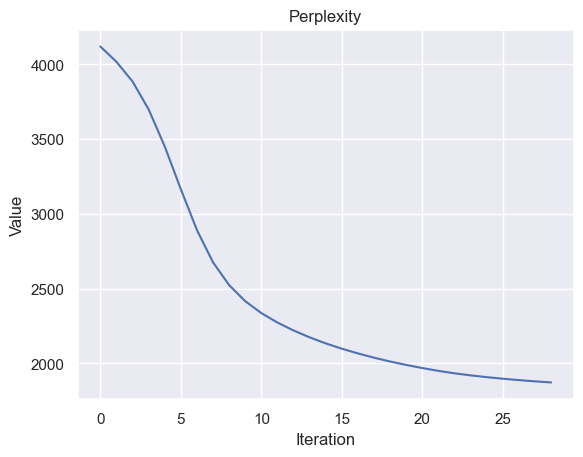

In [12]:
plt.plot(perplexity.history[1:])
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.title('Perplexity')
plt.show()

In [13]:
print(f'Cache size before resetting: {len(perplexity.history)}')
perplexity.reset_history()
print(f'Cache size after resetting: {len(perplexity.history)}')

Cache size before resetting: 30
Cache size after resetting: 0


## Advanced usage of metrics

### Creating a custom metric

Creating a new metric requires creating a subclass of `Metric` base class and implementing `__init__` and `_call_impl` methods. It is recommended to write matrix in pure jax, but it is not strictly necessary.

In [14]:
class PhiNormMetric(Metric):
    def __init__(self, tag: str = None, eps: float = 1e-12):
        if tag is None:
            tag = self.__class__.__name__
        super().__init__(tag=tag)

        self._eps = eps
    
    def _call_impl(self, phi_it: Array, phi_wt: Array, theta: Array) -> float:
        norm = jnp.sum(phi_it)
        return norm

In [15]:
norm_metric = PhiNormMetric()

model = ContextTopicModel(
    vocab_size=len(preprocessor.vocabulary),
    ctx_len=10,
)
model.add_metric(norm_metric)

model.fit(
    data=tokenized_data,
    ctx_bounds=document_bounds,
    max_iter=5,
    verbose=2,
    seed=42,
)

Iteration [1/5], phi update diff norm: 0.1438
  Metrics:
    PhiNormMetric: 392.4722
Iteration [2/5], phi update diff norm: 0.0242
  Metrics:
    PhiNormMetric: 47357.3125
Iteration [3/5], phi update diff norm: 0.0288
  Metrics:
    PhiNormMetric: 47469.7617
Iteration [4/5], phi update diff norm: 0.0409
  Metrics:
    PhiNormMetric: 47774.7695
Iteration [5/5], phi update diff norm: 0.0508
  Metrics:
    PhiNormMetric: 48237.7383


## Usage example

Let's compare batched training with training on full data. We will compare it based on multiple metrics.

In [16]:
# create bag of words for coherence metric
n_docs = len(data)
vocab_size = len(preprocessor.vocabulary)

bow = []
for d in range(n_docs):
    doc_start_idx = document_bounds[d]
    doc_end_idx = document_bounds[d + 1]
    doc_tokens = tokenized_data[doc_start_idx:doc_end_idx]
    bow.append(jnp.add.at(jnp.zeros(vocab_size), doc_tokens, 1, inplace=False))
bow = jnp.array(bow)

assert len(bow) == n_docs
assert bow.sum() == len(tokenized_data)

In [17]:
def fit_with_metrics(config: dict):
    metrics = [
        PerplexityMetric(tag='perplexity'),
        SparsityMetric(tag='sparsity'),
        TopicVarianceMetric(top_k=10, tag='topic variance'),
        CoherenceMetric(data=bow, top_k=10, tag='coherence'),
    ]
    model = ContextTopicModel(
        vocab_size=vocab_size,
        ctx_len=10,
        metrics=metrics,
    )
    model.fit(**config, seed=172)
    return metrics

In [18]:
run_configurations = {
    f'batched training with lr = {lr}': {'data': loader, 'lr': lr}
    for lr in [0.1, 0.01, 0.001]
}
run_configurations['training on full data'] = {'data': tokenized_data, 'ctx_bounds': document_bounds}

metrics = {}
for label, config in run_configurations.items():
    print(f'Started {label}')
    metrics[label] = fit_with_metrics(config)

Started batched training with lr = 0.1
Started batched training with lr = 0.01
Started batched training with lr = 0.001
Started training on full data


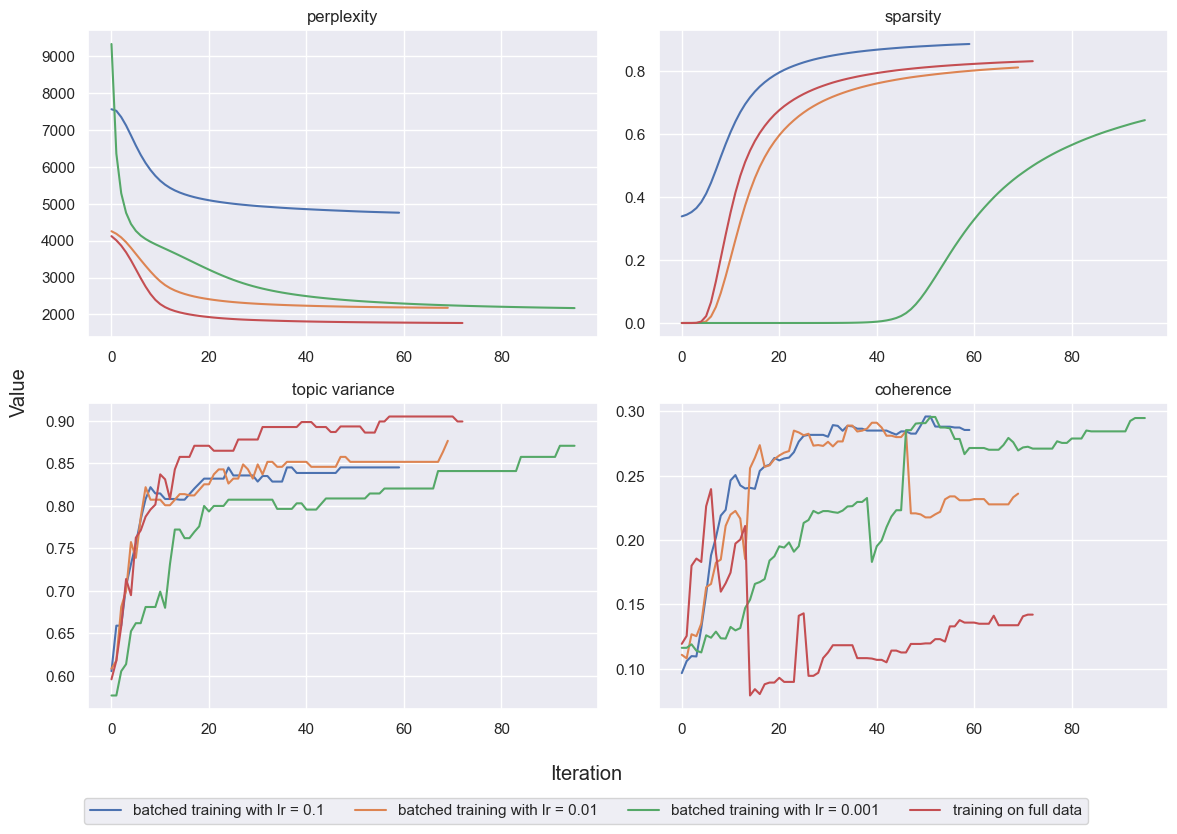

In [19]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
ax = ax.flatten()

lines_labels = []
for label, metric_list in metrics.items():
    for i, metric in enumerate(metric_list):
        line, = ax[i].plot(metric.history[1:], label=label)
        ax[i].set_title(metric.tag)
        lines_labels.append((line, label))

unique_labels = {}
for line, label in lines_labels:
    if label not in unique_labels:
        unique_labels[label] = line

fig.supxlabel('Iteration')
fig.supylabel('Value')
fig.legend(
    unique_labels.values(),
    unique_labels.keys(),
    loc='lower center',
    ncol=len(unique_labels),
    bbox_to_anchor=(0.5, -0.05),
)
fig.tight_layout()
plt.show()